In [67]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import optuna
from optuna.trial import TrialState

In [68]:
TRAIN_PATH = "data/train_FD002.txt"
TEST_PATH  = "data/test_FD002.txt"
RUL_PATH   = "data/RUL_FD002.txt"

In [69]:
SEQ_LEN = 80           # window length (you can try 25–50)
STEP = 1                # stride for training windows
BATCH_SIZE = 128
LR = 0.005296227272721275
EPOCHS = 100
PATIENCE = 20
RUL_CLIP = 200          # cap RUL
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


In [70]:
train_df = pd.read_csv(TRAIN_PATH, sep=" ", header=None).dropna(axis=1, how="all")
test_df  = pd.read_csv(TEST_PATH,  sep=" ", header=None).dropna(axis=1, how="all")
rul_df   = pd.read_csv(RUL_PATH,   sep=" ", header=None)

# consistent columns (first 24 columns typically: unit, cycle, op1..3, s1..21)
cols = ["unit", "cycle"] + [f"op_setting_{i}" for i in range(1,4)] + [f"sensor_{i}" for i in range(1,22)]
train_df = train_df.iloc[:, :len(cols)]
test_df  = test_df.iloc[:, :len(cols)]
train_df.columns = cols
test_df.columns  = cols

In [71]:
train_max = train_df.groupby("unit")["cycle"].max().to_dict()
train_df["RUL"] = train_df.apply(lambda r: train_max[r["unit"]] - r["cycle"], axis=1)
train_df["RUL"] = train_df["RUL"].clip(upper=RUL_CLIP)


In [72]:
rul_vals = rul_df.iloc[:,0].values.flatten()
# rul_vals order is engine 1..N (CMAPSS protocol)
# create a mapping engine -> remaining cycles (RUL_final)
test_rul_map = {unit: int(rval) for unit, rval in zip(sorted(test_df["unit"].unique()), rul_vals)}
# Note: We'll clip later when we construct y_test

In [73]:
selected_features = [
    "op_setting_1","op_setting_2","op_setting_3",
    "sensor_2","sensor_3","sensor_4","sensor_7","sensor_8",
    "sensor_9","sensor_11","sensor_12","sensor_13","sensor_14","sensor_15"
]

In [74]:
train_df = train_df[["unit","cycle"] + selected_features + ["RUL"]]
# test keep features + unit,cycle
test_df = test_df[["unit","cycle"] + selected_features].copy()

# ----------------------------
# 5) Scaling: fit StandardScaler on training features (global)
#    (StandardScaler is preferred here per your guide)
# ----------------------------
scaler = StandardScaler()
train_df[selected_features] = scaler.fit_transform(train_df[selected_features])
test_df[selected_features]  = scaler.transform(test_df[selected_features])

In [75]:
def create_train_sequences(df, seq_len=SEQ_LEN, step=STEP):
    X, y = [], []
    for uid in sorted(df["unit"].unique()):
        unit_df = df[df["unit"] == uid].reset_index(drop=True)
        feats = unit_df[selected_features].values
        labels = unit_df["RUL"].values
        L = len(unit_df)
        # create windows
        for start in range(0, L - seq_len + 1, step):
            end = start + seq_len
            X.append(feats[start:end])
            # label corresponds to last time step of the window (end-1)
            y.append(labels[end-1])
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return X, y

# Build train sequences for all train units
X_all, y_all = create_train_sequences(train_df, SEQ_LEN, STEP)
print(f"All train sequences: {X_all.shape}, {y_all.shape}")




All train sequences: (33219, 80, 14), (33219,)


In [76]:
units = sorted(train_df["unit"].unique())
n_units = len(units)
# default split: first 80% engines train, rest val (or use fixed 1..80,81..100)
train_units = units[: int(n_units * 0.8)]
val_units   = units[int(n_units * 0.8):]

def create_sequences_by_units(df, units_list, seq_len=SEQ_LEN, step=STEP):
    X, y = [], []
    for uid in units_list:
        unit_df = df[df["unit"] == uid].reset_index(drop=True)
        feats = unit_df[selected_features].values
        labels = unit_df["RUL"].values
        L = len(unit_df)
        for start in range(0, L - seq_len + 1, step):
            end = start + seq_len
            X.append(feats[start:end])
            y.append(labels[end-1])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

X_train, y_train = create_sequences_by_units(train_df, train_units, SEQ_LEN, STEP)
X_val,   y_val   = create_sequences_by_units(train_df, val_units,   SEQ_LEN, STEP)

print(f"Train: {X_train.shape}, {y_train.shape}   Val: {X_val.shape}, {y_val.shape}")


Train: (26671, 80, 14), (26671,)   Val: (6548, 80, 14), (6548,)


In [77]:
def build_test_last_windows(test_df, rul_map, seq_len=SEQ_LEN):
    X_test = []
    y_test = []
    units_sorted = sorted(test_df["unit"].unique())
    for uid in units_sorted:
        unit_df = test_df[test_df["unit"] == uid].reset_index(drop=True)
        if len(unit_df) < seq_len:
            # pad at start with first row repeated (rare); simpler to skip but we keep padding
            pad_len = seq_len - len(unit_df)
            pad = np.repeat(unit_df[selected_features].iloc[[0]].values, pad_len, axis=0)
            window = np.vstack([pad, unit_df[selected_features].values])
        else:
            window = unit_df[selected_features].values[-seq_len:]
        X_test.append(window.astype(np.float32))
        # RUL for engine = value from rul_map (this is final remaining cycles)
        true_rul = rul_map[uid]
        y_test.append(min(true_rul, RUL_CLIP))  # apply clipping here
    return np.array(X_test, dtype=np.float32), np.array(y_test, dtype=np.float32), units_sorted

X_test, y_test, test_units = build_test_last_windows(test_df, test_rul_map, SEQ_LEN)
print(f"Test windows: {X_test.shape}, Test labels (engines): {y_test.shape}")


Test windows: (259, 80, 14), Test labels (engines): (259,)


In [78]:
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # shape [N,1]
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SeqDataset(X_train, y_train)
val_ds   = SeqDataset(X_val, y_val)
test_ds  = SeqDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

In [79]:
class SmallGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, dropout=0.1):
        super().__init__()

        # Bi-directional GRU (strong improvement)
        self.gru = nn.GRU(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )

        # Layer norm for stability
        self.norm = nn.LayerNorm(hidden_dim * 2)

        # Fully-connected regression head (more expressive)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        out, _ = self.gru(x)              # (B, T, 2H)
        last = out[:, -1, :]              # last timestep (B, 2H)

        last = self.norm(last)            # normalized representation

        return self.fc(last) 




hyperparameter tune

In [65]:
import optuna
from optuna.trial import TrialState

def objective(trial):

    # === Search Space === #
    hidden_dim  = trial.suggest_categorical("hidden_dim", [32, 64, 128, 256])
    num_layers  = trial.suggest_int("num_layers", 1, 3)
    dropout     = trial.suggest_float("dropout", 0.1, 0.5)
    lr          = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    batch_size  = trial.suggest_categorical("batch_size", [32, 64, 128])
    seq_len     = trial.suggest_categorical("seq_len", [30, 50, 60, 80])

    # === Rebuild Sequences For This Trial === #
    X_train_t, y_train_t = create_sequences_by_units(train_df, train_units, seq_len)
    X_val_t,   y_val_t   = create_sequences_by_units(train_df, val_units,   seq_len)

    train_loader = DataLoader(SeqDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(SeqDataset(X_val_t,   y_val_t),   batch_size=batch_size)

    # === Build Model === #
    model = SmallGRU(
        input_dim=len(selected_features),
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        dropout=dropout
    ).to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.SmoothL1Loss()

    EPOCHS = 50
    best_val = float("inf")
    patience = 7
    wait = 0

    # === Training Loop === #
    for epoch in range(EPOCHS):

        model.train()
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            pred = model(Xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

        # === Validation === #
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
                pred = model(Xb)
                val_loss += criterion(pred, yb).item()
        val_loss /= len(val_loader)

        # Report to Optuna
        trial.report(val_loss, epoch)

        # Pruning → kills bad trials early
        if trial.should_prune():
            raise optuna.TrialPruned()

        # Early stopping logic
        if val_loss < best_val:
            best_val = val_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break

    return best_val


In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40)   # you can try 50, 80, 100

print("Best hyperparameters:")
print(study.best_params)


In [ ]:
## model Training

In [80]:

model = SmallGRU(input_dim=len(selected_features), hidden_dim=32, num_layers=1, dropout=0.1997521681157765).to(DEVICE)


c:\Python312\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1997521681157765 and num_layers=1
  warnings.warn(


In [81]:
criterion = nn.SmoothL1Loss()   # Huber-like loss (more robust)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5
)



In [82]:
mae_fn = torch.nn.L1Loss()  # MAE function

best_val = float("inf")
wait = 0

train_losses = []
val_losses = []
train_mae_list = []
val_mae_list = []

best_epoch = -1

for epoch in range(1, EPOCHS + 1):
    
    # -----------------------
    # TRAINING
    # -----------------------
    model.train()
    tloss = 0.0
    tmae  = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)

        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

        tloss += loss.item() * Xb.size(0)
        tmae  += mae_fn(pred, yb).item() * Xb.size(0)

    tloss = tloss / len(train_loader.dataset)
    tmae  = tmae  / len(train_loader.dataset)

    train_losses.append(tloss)
    train_mae_list.append(tmae)

    # -----------------------
    # VALIDATION
    # -----------------------
    model.eval()
    vloss = 0.0
    vmae  = 0.0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)

            pred = model(Xb)
            loss = criterion(pred, yb)

            vloss += loss.item() * Xb.size(0)
            vmae  += mae_fn(pred, yb).item() * Xb.size(0)

    vloss = vloss / len(val_loader.dataset)
    vmae  = vmae  / len(val_loader.dataset)

    val_losses.append(vloss)
    val_mae_list.append(vmae)

    # Step LR scheduler using val loss
    scheduler.step(vloss)

    # Display metrics
    print(
        f"Epoch {epoch:03d} | "
        f"Train Loss: {tloss:.4f} | Val Loss: {vloss:.4f} | "
        f"Train MAE: {tmae:.4f} | Val MAE: {vmae:.4f}"
    )

    # -----------------------
    # EARLY STOPPING
    # -----------------------
    if vloss < best_val - 1e-6:
        best_val = vloss
        best_epoch = epoch
        wait = 0
        torch.save(model.state_dict(), "best_gru_fd002_fixed.pth")
        print(f"  -> New best model saved (Val Loss: {best_val:.6f})")
    else:
        wait += 1
        if wait >= PATIENCE:
            print(f"Early stopping after {epoch} epochs. Best epoch: {best_epoch}")
            break

# Load best model
model.load_state_dict(torch.load("best_gru_fd002_fixed.pth", map_location=DEVICE))


Epoch 001 | Train Loss: 30.0185 | Val Loss: 20.1957 | Train MAE: 30.5138 | Val MAE: 20.6883
  -> New best model saved (Val Loss: 20.195680)
Epoch 002 | Train Loss: 17.3175 | Val Loss: 14.6596 | Train MAE: 17.8075 | Val MAE: 15.1474
  -> New best model saved (Val Loss: 14.659599)
Epoch 003 | Train Loss: 14.5301 | Val Loss: 13.5870 | Train MAE: 15.0188 | Val MAE: 14.0730
  -> New best model saved (Val Loss: 13.586962)
Epoch 004 | Train Loss: 13.5861 | Val Loss: 14.4499 | Train MAE: 14.0726 | Val MAE: 14.9374
Epoch 005 | Train Loss: 13.4878 | Val Loss: 13.2428 | Train MAE: 13.9749 | Val MAE: 13.7289
  -> New best model saved (Val Loss: 13.242770)
Epoch 006 | Train Loss: 13.0391 | Val Loss: 13.9844 | Train MAE: 13.5253 | Val MAE: 14.4707
Epoch 007 | Train Loss: 12.2813 | Val Loss: 16.5206 | Train MAE: 12.7659 | Val MAE: 17.0089
Epoch 008 | Train Loss: 11.9046 | Val Loss: 14.2693 | Train MAE: 12.3905 | Val MAE: 14.7558
Epoch 009 | Train Loss: 11.1005 | Val Loss: 14.3298 | Train MAE: 11.5858

<All keys matched successfully>

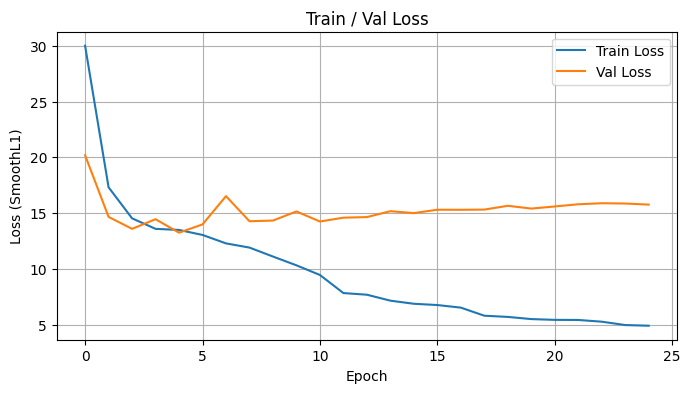

In [83]:
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (SmoothL1)")
plt.title("Train / Val Loss")
plt.legend()
plt.grid(True)
plt.show()

In [84]:
model.eval()
preds = []
with torch.no_grad():
    for Xb, _ in test_loader:
        Xb = Xb.to(DEVICE)
        out = model(Xb)                 # shape (batch,1)
        preds.extend(out.cpu().numpy().flatten())

preds = np.array(preds).flatten()
# preds correspond to engines in test_units order
# y_test we built earlier is clipped RUL from rul_map; use that for metric
y_true = y_test.copy()

# compute RMSE (per-engine)
rmse = math.sqrt(mean_squared_error(y_true, preds))
print(f"TEST RMSE (per-engine): {rmse:.6f}")

TEST RMSE (per-engine): 28.447441


In [86]:

print("\nEngine | True RUL | Predicted RUL")
for u, t, p in zip(test_units, y_true, preds):
    print(f"{u:3d}    {t:7.2f}     {p:7.2f}")


Engine | True RUL | Predicted RUL
  1      18.00       10.12
  2      79.00       85.67
  3     106.00      114.37
  4     110.00       70.55
  5      15.00       18.17
  6     155.00      105.80
  7       6.00        4.57
  8      90.00       62.88
  9      11.00       11.13
 10      79.00       84.15
 11       6.00        6.38
 12      73.00       76.20
 13      30.00       28.31
 14      11.00       10.07
 15      37.00       36.75
 16      67.00       91.43
 17      68.00       47.18
 18      99.00      180.88
 19      22.00       26.42
 20      54.00       64.32
 21      97.00       92.65
 22      10.00       10.08
 23     142.00       70.40
 24      77.00       70.03
 25      88.00       78.85
 26     163.00      153.35
 27     126.00      154.72
 28     138.00       66.47
 29      83.00       86.04
 30      78.00       56.28
 31      75.00       97.48
 32      11.00       16.61
 33      53.00       56.36
 34     173.00      216.01
 35      63.00       60.57
 36     100.00      

In [87]:
print("len(y_true):", len(y_true))
print("len(preds):", len(preds))
print("len(test_units):", len(test_units))


len(y_true): 259
len(preds): 259
len(test_units): 259


In [101]:
import torch
import torch.nn as nn

selected_features = [
    "op_setting_1","op_setting_2","op_setting_3",
    "sensor_2","sensor_3","sensor_4","sensor_7","sensor_8",
    "sensor_9","sensor_11","sensor_12","sensor_13","sensor_14","sensor_15"
]

class SmallGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, dropout=0.1):
            super().__init__()

            # Bi-directional GRU (strong improvement)
            self.gru = nn.GRU(
                input_dim,
                hidden_dim,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout,
                bidirectional=True
            )

            # Layer norm for stability
            self.norm = nn.LayerNorm(hidden_dim * 2)

            # Fully-connected regression head (more expressive)
            self.fc = nn.Sequential(
                nn.Linear(hidden_dim * 2, 128),
                nn.ReLU(),
                nn.Dropout(0.1),

                nn.Linear(128, 64),
                nn.ReLU(),

                nn.Linear(64, 1)
            )

    def forward(self, x):
            out, _ = self.gru(x)              # (B, T, 2H)
            last = out[:, -1, :]              # last timestep (B, 2H)

            last = self.norm(last)            # normalized representation

            return self.fc(last) 




DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SmallGRU(input_dim=len(selected_features), hidden_dim=32, num_layers=1, dropout=0.1997521681157765).to(DEVICE)

model.load_state_dict(torch.load("best_gru_fd002_fixed.pth", map_location=DEVICE))

model.eval()

print("Loaded model successfully!")


Loaded model successfully!


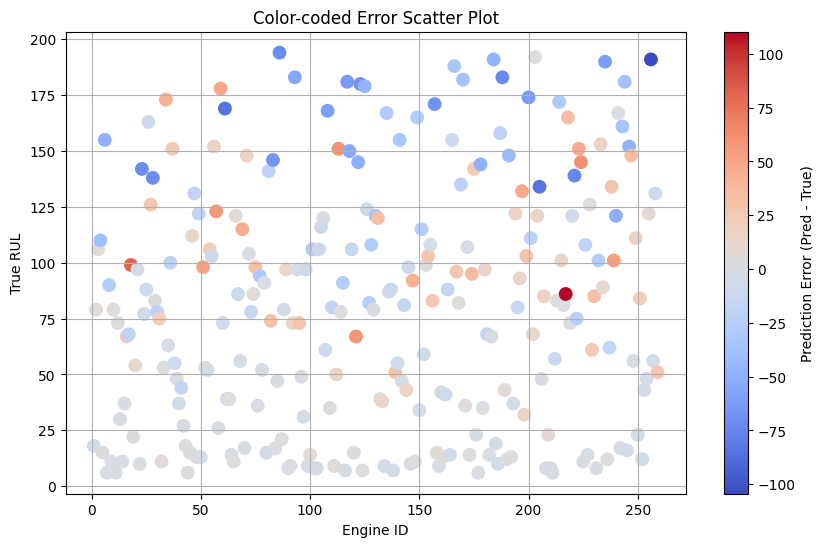

In [102]:
errors = preds - y_true

plt.figure(figsize=(10,6))
plt.scatter(test_units, y_true, c=errors, cmap="coolwarm", s=80)
plt.colorbar(label="Prediction Error (Pred - True)")
plt.xlabel("Engine ID")
plt.ylabel("True RUL")
plt.title("Color-coded Error Scatter Plot")
plt.grid(True)
plt.show()


In [103]:
# %%
import pickle

SCALER_PATH = "scaler_fd002.pkl"

with open(SCALER_PATH, "wb") as f:
    pickle.dump(scaler, f)

print("Scaler saved to:", SCALER_PATH)


Scaler saved to: scaler_fd002.pkl


In [104]:
# %%
import pickle
import torch

# Load scaler
with open("scaler_fd002.pkl", "rb") as f:
    loaded_scaler = pickle.load(f)

# Load model

model = SmallGRU(input_dim=len(selected_features), hidden_dim=32, num_layers=1, dropout=0.1997521681157765).to(DEVICE)

model.load_state_dict(torch.load("best_gru_fd002_fixed.pth", map_location=DEVICE))

model.to(DEVICE)
model.eval()

print("Model + Scaler loaded successfully.")


Model + Scaler loaded successfully.


In [105]:
# %%
UNSEEN_PATH = "data/test_FD002.txt"
UNSEEN_TRUE_RUL_PATH = "data/RUL_FD002.txt"   # Must contain RUL values line-by-line

# Load unseen dataset
unseen_df = pd.read_csv(UNSEEN_PATH, sep=" ", header=None).dropna(axis=1, how="all")
unseen_df = unseen_df.iloc[:, :len(cols)]
unseen_df.columns = cols

# Keep only features
unseen_df = unseen_df[["unit","cycle"] + selected_features]

# Apply saved scaler
unseen_df[selected_features] = loaded_scaler.transform(unseen_df[selected_features])

print(unseen_df.head())


   unit  cycle  op_setting_1  op_setting_2  op_setting_3  sensor_2  sensor_3  \
0     1      1     -0.949310     -1.038202      0.418187  0.680028  0.728668   
1     1      2     -0.270953      0.412704      0.418187  0.754849  0.577930   
2     1      3      0.746315      0.864298      0.418187 -0.634835 -0.574740   
3     1      4      1.221123      0.867523      0.418187 -0.791181 -0.663370   
4     1      5      0.067816      0.158844     -2.391275 -1.151877 -1.574312   

   sensor_4  sensor_7  sensor_8  sensor_9  sensor_11  sensor_12  sensor_13  \
0  0.835679  0.766645  0.620355  0.710521   0.812051   0.767270   0.418708   
1  0.341397  0.354464  0.654719  0.559870   0.394398   0.357777   0.418240   
2 -0.647083 -0.609961 -0.042761 -0.550911  -0.366661  -0.603153   0.415351   
3 -0.651028 -0.985362 -0.119133 -0.629378  -0.239818  -0.985550   0.415116   
4 -1.299102 -0.731876 -2.160888 -1.572534  -1.925902  -0.737399  -2.393334   

   sensor_14  sensor_15  
0   0.559923  -0.910220 

In [106]:
# %%
def build_unseen_last_windows(df, seq_len=SEQ_LEN):
    X = []
    units_sorted = sorted(df["unit"].unique())
    
    for uid in units_sorted:
        unit_df = df[df["unit"] == uid].reset_index(drop=True)
        
        if len(unit_df) < seq_len:
            pad_len = seq_len - len(unit_df)
            pad = np.repeat(unit_df[selected_features].iloc[[0]].values, pad_len, axis=0)
            window = np.vstack([pad, unit_df[selected_features].values])
        else:
            window = unit_df[selected_features].values[-seq_len:]
            
        X.append(window.astype(np.float32))
        
    return np.array(X, dtype=np.float32), units_sorted

X_unseen, unseen_units = build_unseen_last_windows(unseen_df, SEQ_LEN)
print("X_unseen shape:", X_unseen.shape)


X_unseen shape: (259, 80, 14)


In [107]:
# %%
true_rul_vals = np.loadtxt(UNSEEN_TRUE_RUL_PATH)
y_unseen = true_rul_vals.astype(np.float32)

print("Loaded true RUL shape:", y_unseen.shape)


Loaded true RUL shape: (259,)


In [108]:
# %%
X_unseen_tensor = torch.tensor(X_unseen, dtype=torch.float32).to(DEVICE)

preds_unseen = []
with torch.no_grad():
    out = model(X_unseen_tensor)
    preds_unseen = out.cpu().numpy().flatten()

preds_unseen = np.array(preds_unseen)


In [109]:
# %%
print("\nEngine | True RUL | Predicted RUL")
for u, t, p in zip(unseen_units, y_unseen, preds_unseen):
    print(f"{u:3d}    {t:7.2f}     {p:7.2f}")

rmse_unseen = math.sqrt(mean_squared_error(y_unseen, preds_unseen))
print("\nUNSEEN DATA RMSE:", rmse_unseen)



Engine | True RUL | Predicted RUL
  1      18.00       10.12
  2      79.00       85.67
  3     106.00      114.37
  4     110.00       70.55
  5      15.00       18.17
  6     155.00      105.80
  7       6.00        4.57
  8      90.00       62.88
  9      11.00       11.13
 10      79.00       84.15
 11       6.00        6.38
 12      73.00       76.20
 13      30.00       28.31
 14      11.00       10.07
 15      37.00       36.75
 16      67.00       91.43
 17      68.00       47.18
 18      99.00      180.88
 19      22.00       26.42
 20      54.00       64.32
 21      97.00       92.65
 22      10.00       10.08
 23     142.00       70.40
 24      77.00       70.03
 25      88.00       78.85
 26     163.00      153.35
 27     126.00      154.72
 28     138.00       66.47
 29      83.00       86.04
 30      78.00       56.28
 31      75.00       97.48
 32      11.00       16.61
 33      53.00       56.36
 34     173.00      216.01
 35      63.00       60.57
 36     100.00      

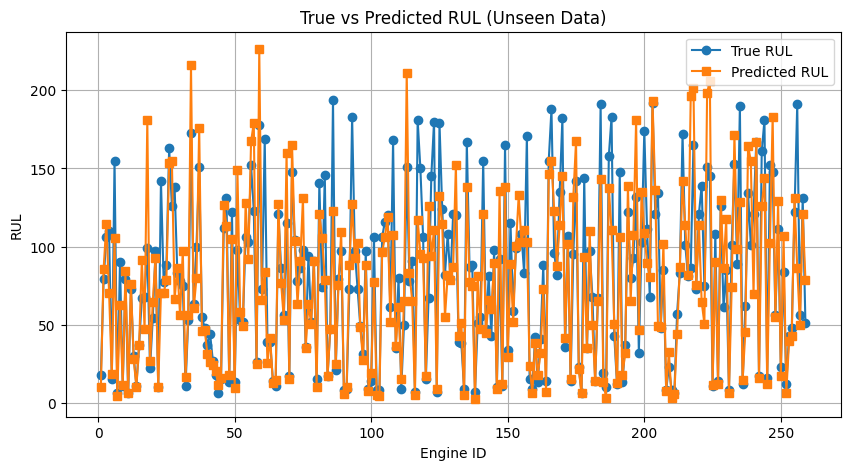

In [110]:
# %%
plt.figure(figsize=(10,5))
plt.plot(unseen_units, y_unseen, marker='o', label="True RUL")
plt.plot(unseen_units, preds_unseen, marker='s', label="Predicted RUL")

plt.title("True vs Predicted RUL (Unseen Data)")
plt.xlabel("Engine ID")
plt.ylabel("RUL")
plt.grid(True)
plt.legend()
plt.show()


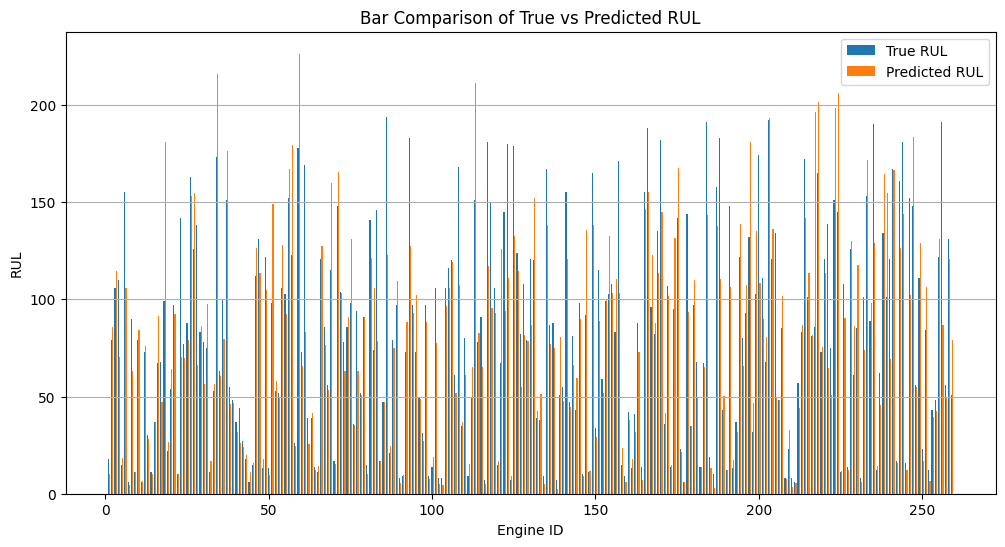

In [111]:
# %%
plt.figure(figsize=(12,6))
width = 0.35

plt.bar(unseen_units, y_unseen, width=width, label="True RUL")
plt.bar(unseen_units + np.array([width]*len(unseen_units)), preds_unseen, width=width, label="Predicted RUL")

plt.title("Bar Comparison of True vs Predicted RUL")
plt.xlabel("Engine ID")
plt.ylabel("RUL")
plt.legend()
plt.grid(axis='y')
plt.show()


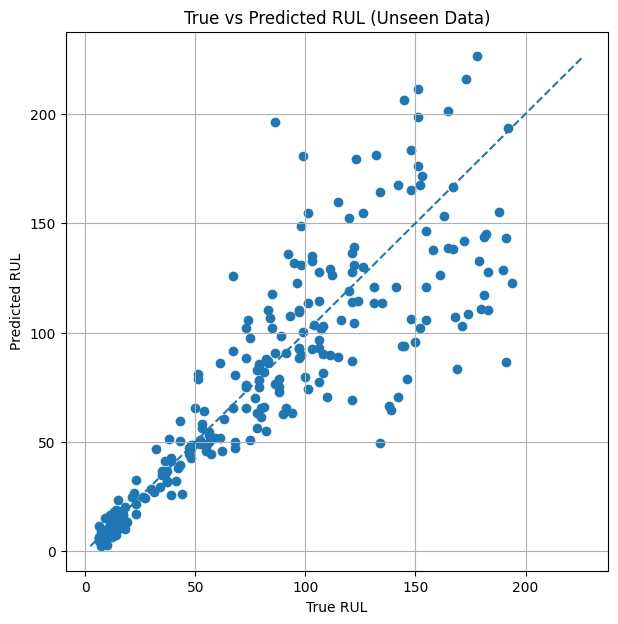

In [112]:
# %%
plt.figure(figsize=(7,7))

plt.scatter(y_unseen, preds_unseen)

plt.title("True vs Predicted RUL (Unseen Data)")
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.grid(True)

# Optional: Add a diagonal reference line
min_val = min(min(y_unseen), min(preds_unseen))
max_val = max(max(y_unseen), max(preds_unseen))
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--')

plt.show()
